## Data Visualisation - Exploring multiple time series
*A miscellany of python plotting functions to draw out features of data distributed over time and space. This is not meant to be a comprehensive exploration of a particular dataset - just a gathering together of helpful functions created during the datathon.*

JW 6/3/23

### [The Data](#1)
Kaggle WiDS 2023 dataset. ie 2 full years of data from 514 locations in the US. This consists of :-
- location specific data (lat, lon, elevation, climate region)
- global data ie independent of location (time series of climate features eg relating to wind, sea surface temperature, mei etc)
- local time series (local weather features and forcasts eg relating to wind, precipitation, temperature)


### [Spatial Distributions](#2)
- How do features vary by location?
- How are the climate region categories distributed?
- How does the prediction target vary over the year?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches
import matplotlib as mpl

In [2]:
# styling
h1 = {'fontsize': 18, 'va': 'top'}
h4 = {'fontsize': 10, 'style': 'italic','alpha': 0.8}

plt.style.use('ww.mplstyle')

c = {'fg' : 'royalblue', 'ot': 'darkorange', 'bg': 'dimgrey'}


## <a class="anchor" id="1">1. Get the data</a>

In [3]:
input_train = "data/train_data.csv"    # full dataset
#input_train = "data/train_sample30k.csv" # sample for testing

train = pd.read_csv(input_train, index_col=["index"], parse_dates=["startdate"], infer_datetime_format=True) 
train.info()

target = 'contest-tmp2m-14d__tmp2m'

#y = train_df[target]     # target
#X = train_df.drop(columns = [target]) # features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375734 entries, 0 to 375733
Columns: 245 entries, lat to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(3), object(1)
memory usage: 705.2+ MB


## <a class="anchor" id="2">2. Spatial Distributions</a>

### 2.1  How do features vary by location?

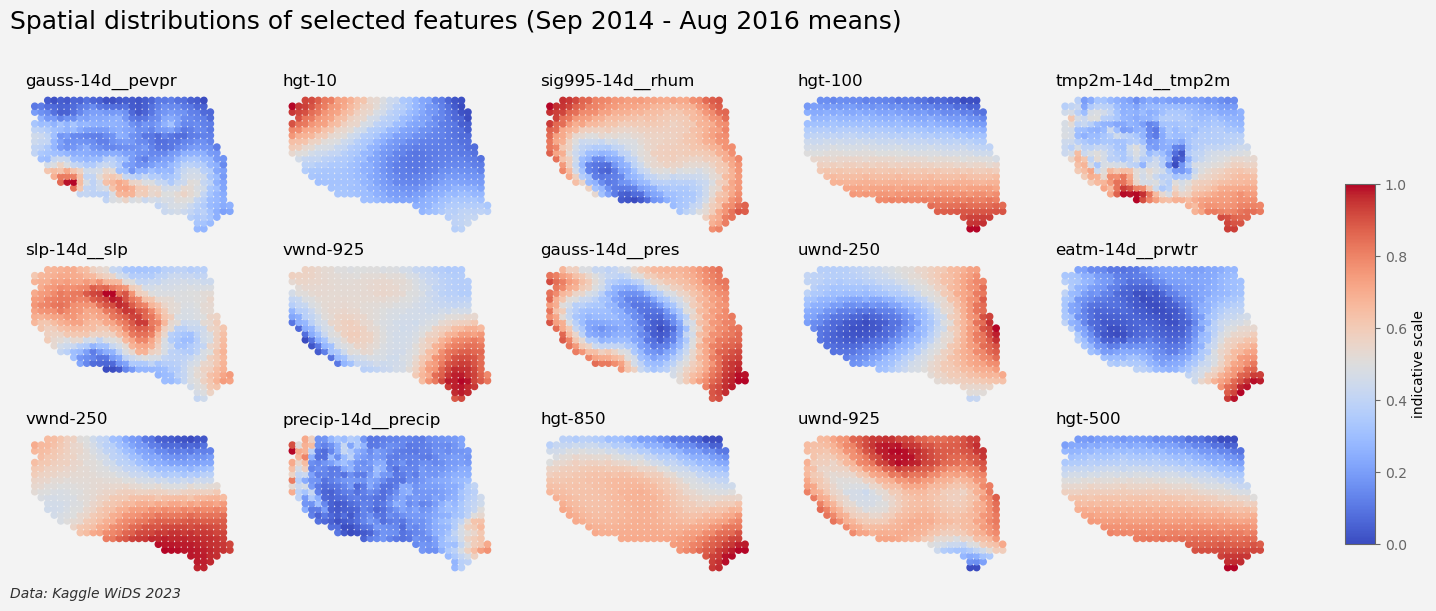

In [4]:
def plot_feats_by_loc(df, features, title):
# plot small multiples of features by lat/lon
    n = len(features)
    cols = 5
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    for i, feat in enumerate(features):
        row, col = i//cols, i%cols
        # reduce length of feature name for nicer plotting (take last components)
        feat_name = '-'.join(feat.split('-')[-2:])   
        
        axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df[feat], s=20, cmap='coolwarm')
        axs[row,col].set_title(feat_name, fontsize=12)
        axs[row,col].set_axis_off()
        
    fig.subplots_adjust(.02,.05,.85,.85)
    
   # indicative colorbar 
    cax = fig.add_axes([.9,.1,.02,.6])
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, label='indicative scale')
    
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig

    
# the data - lat, lon and selected features averaged over time
features = [x for x in train.columns if x.split('-')[0] == 'contest'] 
df = train[['lat','lon'] + features].groupby(['lat','lon']).mean().reset_index()
# print a sample
#print(df.iloc[:3,:3])
#print(features)

fig = plot_feats_by_loc(df, features, title="Spatial distributions of selected features (Sep 2014 - Aug 2016 means)")
plt.savefig("vis/A1_spatial_contest_feat_mean.jpg") 
plt.show()

#### Observations
- The sites are gridded and appear to cover the US (lat/lons provided have already been scaled between 0 and 1. Precise locations can't be identified)
- There are clear spatial patterns to most features
- The prediction target (tmp2m-14d__tmp2m) shows more complex variation by location than most of these features (on average). 
- 14d__wind-hgt-100 and 14d__wind-hgt-500 on average seem to vary largely by latitude alone and show similar spatial distributions. Consider removing from analysis.

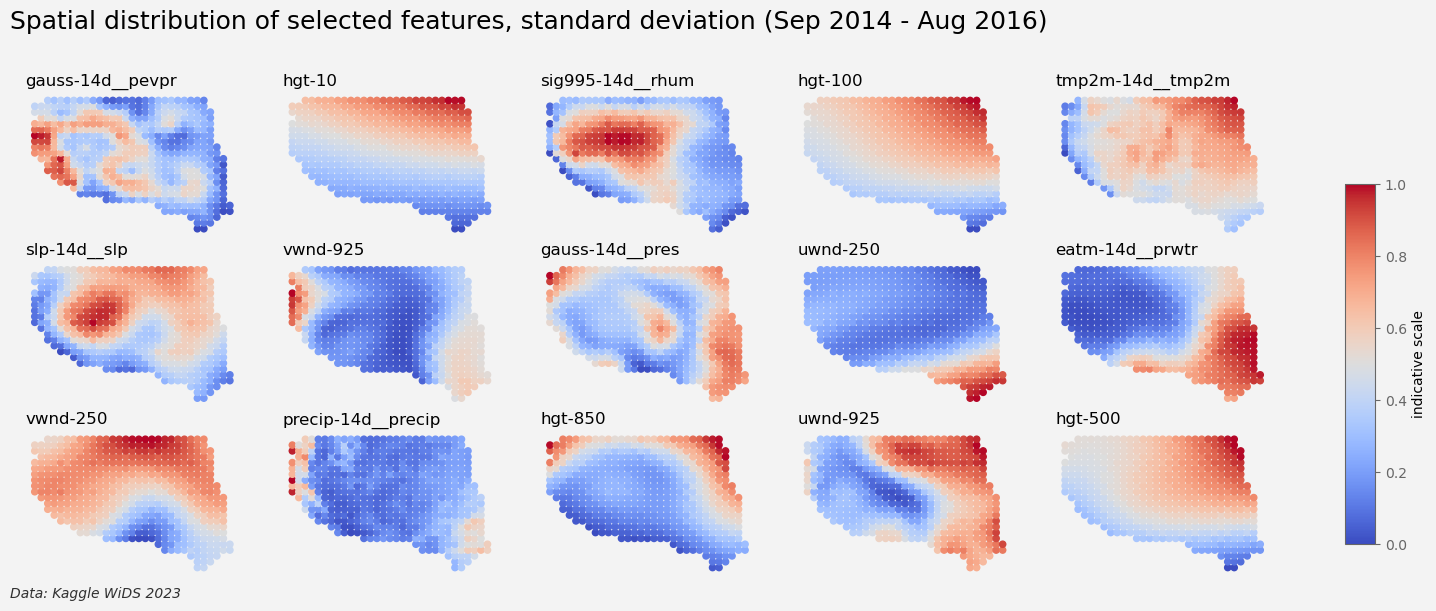

In [5]:
# the data - lat, lon and standard deviation of selected features over time
features = [x for x in train.columns if x.split('-')[0] == 'contest'] 
df = train[['lat','lon'] + features].groupby(['lat','lon']).std().reset_index()
#print(df.iloc[:3,:3])

fig = plot_feats_by_loc(df, features, title="Spatial distribution of selected features, standard deviation (Sep 2014 - Aug 2016)")
plt.savefig("vis/A1_spatial_contest_feat_std.jpg")
plt.show()

#### Observations
- Features vary over time differently according to location. For example the prediction target (tmp2m-14d__tmp2m) is most variable in the North East and least variable in the far West.

### 2.2 How are the climateregion categories distributed?

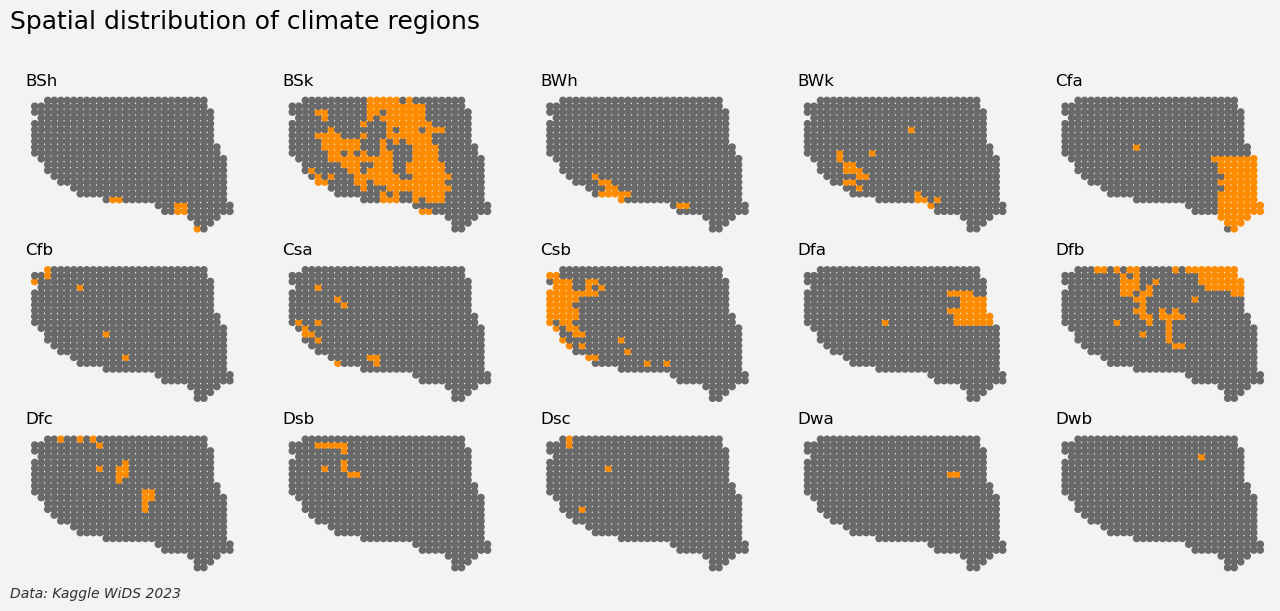

In [6]:
def plot_cats_by_loc(df, f_cat, title):
    cats = np.sort(df[f_cat].unique())
    n = len(cats)
    cols = 5
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows,cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    for i, cat in enumerate(cats):
        # create colour feature
        df['colour'] = [c['bg']] * len(df)
        df.loc[df.loc[:,f_cat] == cat, 'colour'] = c['ot']
        
        row, col = i//cols, i%cols
        axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df['colour'], s=20)
        axs[row,col].set_title(cat, fontsize=12)
        axs[row,col].set_axis_off()
    
    fig.subplots_adjust(.02,.05,.85,.85)
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig
    

# the data - lat, lon and category
df = train[['lat','lon','climateregions__climateregion']].groupby(['lat','lon','climateregions__climateregion']).mean()
df = df.reset_index()
#print(df.head(3))

plot_cats_by_loc(df, 'climateregions__climateregion', title="Spatial distribution of climate regions")
plt.savefig("vis/A1_climateregion_distn.jpg")
plt.show()

#### Observations
- The categories vary considerably in size. BSk dominates. Dwa, Dwb are very small.
- Climate regions tend to be clustered geographically though several consist of a number of 'islands'. eg Dfc.  
- A few locations are categorised differently to all their nearest neighbours. 
- The general climate category distribution shares some features with the mean temperature distributon. eg Dfc locations tend to be the coldest, BWh the hottest.

### 2.3 How does the target vary geographically across the year

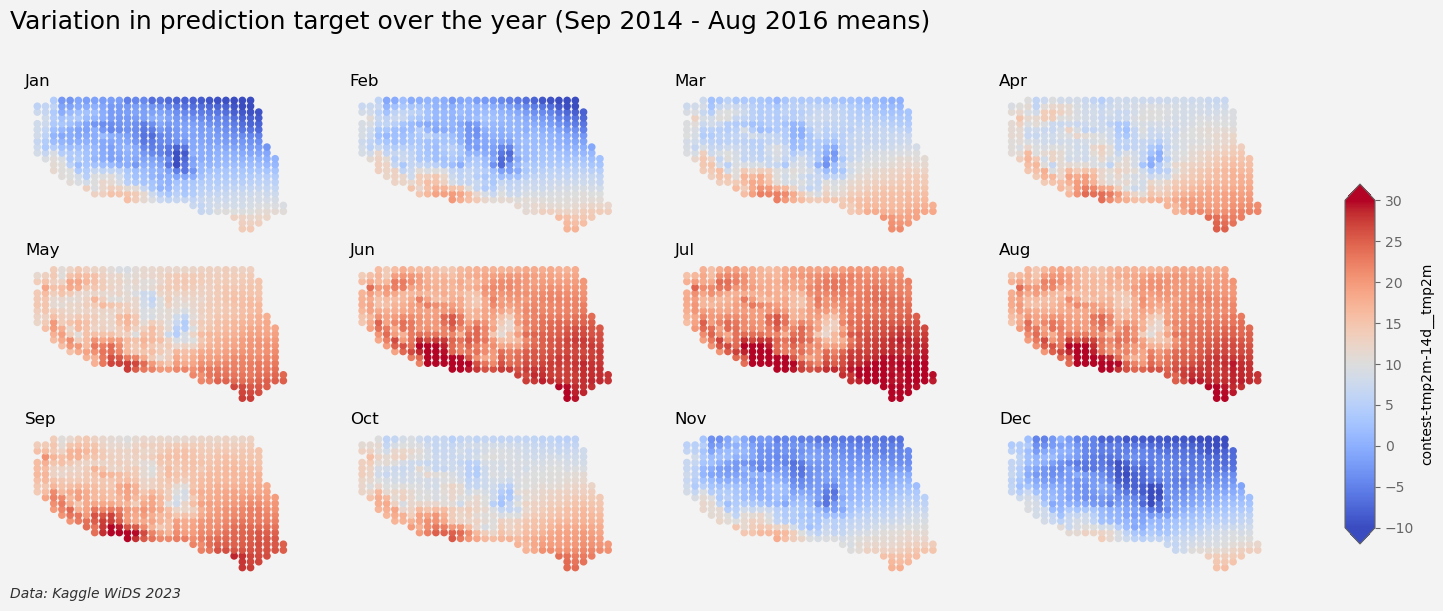

In [7]:
def plot_mm_by_loc(df, title):
# plot small multiples of features by lat/lon
    n = 12
    cols = 4
    rows = (n-1)//cols + 1

    fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(15,2*rows), sharey=True, sharex=True)

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        row, col = i//cols, i%cols
        
        locs = axs[row,col].scatter(x=df['lon'], y = df['lat'], c=df[i+1], s=20, cmap='coolwarm', vmin=-10, vmax=30,)
        axs[row,col].set_title(month, fontsize=12)
        axs[row,col].set_axis_off()
        
    fig.subplots_adjust(.02,.05,.85,.85)
    
    cax = fig.add_axes([.9,.1,.02,.6])
    fig.colorbar(locs, cax=cax, label=target, extend='both')
    
    fig.text(.01,.99,title, fontdict=h1) 
    fig.text(.01,.01,"Data: Kaggle WiDS 2023", fontdict=h4) 
    return fig

    
# set up the data - lat, lon and monthly means of prediction target
grps = train[['lat','lon','startdate',target]].groupby(['lat','lon'])

records = []
for latlon, grp in grps:
    # calculate monthly mean
    mm = grp.groupby(grp['startdate'].dt.month)[target].mean()
    mm['lat'], mm['lon'] = latlon
    records.append(mm)
df = pd.DataFrame(records).reset_index(drop=True)

#print(df.iloc[:3,-3:])

plot_mm_by_loc(df, title="Variation in prediction target over the year (Sep 2014 - Aug 2016 means)")
plt.savefig("vis/A1_spatial_monthly_dist.jpg")
plt.show()

#### Observations
- as expected there are clear seasonal variations with warmer summer months and cooler winter months
- some of the small climateregions categories do not stand out on these plots. Consider combining with larger categories eg Dwa and Dwb with neighbouring categories.